## Imports

In [2]:
import csv
import obspy
from obspy import signal
import obspy.signal.filter
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import random
import pandas as pd
from joblib import dump, load
import os
from datetime import datetime, timedelta

In [3]:
CONTEXT_WINDOW = 90
SAMPLES = 7601

## Positive Examples

In [4]:
#get all events
def get_full_event_list(path = "../Data/allevents.csv"):
    all = pd.read_csv(path)
    keep = ['year', 'day', 'date', 'oTime', 'pTime', 'sTime', 'spTime', 'distance', 'duration', 'quality', 'type']
    events = all[keep]
    events = events[events['year']> 1999]
    return events[4:]

In [5]:
def slice_and_filter(time, stream):
    stream = stream.slice(starttime=time-5, endtime=time+CONTEXT_WINDOW)
    return stream

In [6]:
def get_positive_data(path, event_list):
    clean_data = []
    extra_data = []
    for _, row in event_list.iterrows():
        HHE = path+f"{row['year']}/MN/WDD/HHE.D/MN.WDD..HHE.D.{row['year']}.{str(row['day']).zfill(3)}"
        HHN = path+f"{row['year']}/MN/WDD/HHN.D/MN.WDD..HHN.D.{row['year']}.{str(row['day']).zfill(3)}"
        HHZ = path+f"{row['year']}/MN/WDD/HHZ.D/MN.WDD..HHZ.D.{row['year']}.{str(row['day']).zfill(3)}"
        
        try:    
            st = obspy.read(HHE)
            st += obspy.read(HHN)
            st += obspy.read(HHZ)
            
            quakeTime = obspy.UTCDateTime(row['date']+row['pTime'])
            st = slice_and_filter(quakeTime, st)
            if len(st) == 3 and len(st[0]) == SAMPLES and len(st[1]) == SAMPLES and len(st[2]) == SAMPLES:
                clean_data.append(st)
                extra_data.append([row['day'], row['date'], row['pTime'], row['quality'], row['endTime']])
        except Exception as e:
            print(f"Missing File {row['year']}, {row['day']}")
            continue

    return clean_data, extra_data

In [7]:
def make_utc_list(events):
    utc_times = []
    for _, row in events.iterrows():
        utc_times.append(obspy.UTCDateTime(row['date']+row['oTime']))
    return utc_times

In [8]:
def create_neg_examples(path, events, amount, years):
    # Initialize an empty list to store the negative examples
    negative_examples = []
    times = []
    # Loop to generate random negative examples
    while len(negative_examples) < amount:

        ran_day = random.randint(1, 365)
        ran_hr = random.randint(0, 23)
        ran_min = random.randint(0, 59)
        ran_sec = random.randint(0, 59)
        ran_year = random.choice(years)

        if ran_day == 97 and ran_year == 2010:
            continue

        # Generate a random UTC time on the selected day
        random_utc_time = obspy.UTCDateTime(year=ran_year, julday=ran_day, hour=ran_hr, minute=ran_min, second=ran_sec)
        flag = False

        for _, row in events.iterrows():
            if (random_utc_time < row['oTimeUTC']+row['max_of_dur_cont']) and (random_utc_time+timedelta(0, CONTEXT_WINDOW) > row['oTimeUTC']):
                #there is overlap
                flag = True

        #if no Overlap
        if not flag:
            HHE = path+f"{ran_year}/MN/WDD/HHE.D/MN.WDD..HHE.D.{ran_year}.{str(ran_day).zfill(3)}"
            HHN = path+f"{ran_year}/MN/WDD/HHN.D/MN.WDD..HHN.D.{ran_year}.{str(ran_day).zfill(3)}"
            HHZ = path+f"{ran_year}/MN/WDD/HHZ.D/MN.WDD..HHZ.D.{ran_year}.{str(ran_day).zfill(3)}"

            try:
                st = obspy.read(HHE)
                st += obspy.read(HHN)
                st += obspy.read(HHZ)

                st = slice_and_filter(random_utc_time, st)
                if len(st) == 3 and len(st[0]) == SAMPLES and len(st[1]) == SAMPLES and len(st[2]) == SAMPLES:
                    negative_examples.append(st)
                    times.append(random_utc_time)

            except Exception as e:
                continue
                
    return negative_examples, times

### Transformations to Reshape data Into Form

In [9]:
def to_utc(date, time):
    return obspy.UTCDateTime(date+time)

In [10]:
def duration_type(duration_string):
    time_parts = duration_string.split(':')
    duration_timedelta = timedelta(hours=int(time_parts[0]),
                                        minutes=int(time_parts[1]),
                                        seconds=float(time_parts[2]))
    return duration_timedelta


In [11]:
def end_time(start, end):
    return start+end

In [12]:
def max_window(duration, window):
    return max(duration, window)

In [13]:
def apply_fft(data):
    fft_data = np.fft.fft(data)
    return np.abs(fft_data)

# Run The Above

In [14]:
#get whole event list
all_events = get_full_event_list('../Data/allevents.csv')

#reshape event list
all_events['oTimeUTC'] = all_events.apply(lambda row: to_utc(row['date'], row['oTime']), axis=1)
all_events['duration_format'] = all_events['duration'].apply(duration_type)
all_events['endTime'] = all_events.apply(lambda row: end_time(row['oTimeUTC'], row['duration_format']), axis=1)
all_events['max_of_dur_cont'] = all_events.apply(lambda row: max_window(row['duration_format'], timedelta(0, CONTEXT_WINDOW)), axis=1)
all_events = all_events.drop(columns=['duration', 'duration_format'])

#split by date
X_train_pos = all_events[all_events['year'] <= 2011]

#run above functions
X_train_earthquake_data, X_train_pos_details = get_positive_data('../Data/', X_train_pos)
X_train_earthquake_data = np.array(X_train_earthquake_data)
X_train_class_count = len(X_train_earthquake_data)
X_train_earthquake_labels = np.asarray([1] * X_train_class_count)
X_train_noise_data, X_train_noise_times = create_neg_examples('../Data/', all_events, X_train_class_count, list(range(2000, 2012)))
X_train_noise_labels = np.asarray([0] * X_train_class_count)

#building training sets
X_train = np.concatenate((X_train_earthquake_data, X_train_noise_data), axis=0)
y_train = np.concatenate((X_train_earthquake_labels, X_train_noise_labels), axis=0)
train_details = {"Positive": X_train_pos_details,"Noise": X_train_noise_times}

dump(X_train, "../Dump3/raw_X_Train.joblib")
dump(y_train, "../Dump3/y_Train.joblib")
dump(train_details, "../Dump3/train_details.joblib")

#same as above, but for test
X_test_pos = all_events[all_events['year'] > 2011]

X_test_earthquake_data, X_test_pos_details = get_positive_data('../Data/', X_test_pos)
X_test_earthquake_data = np.array(X_test_earthquake_data)
X_test_class_count = len(X_test_earthquake_data)
X_test_earthquake_labels = np.asarray([1] * X_test_class_count)
X_test_noise_data, X_test_noise_times = create_neg_examples('../Data/', all_events, X_test_class_count, list(range(2012, 2015)))
X_test_noise_labels = np.asarray([0] * X_test_class_count)

X_test = np.concatenate((X_test_earthquake_data, X_test_noise_data), axis=0)
y_test = np.concatenate((X_test_earthquake_labels, X_test_noise_labels), axis=0)
test_details = {"Positive": X_test_pos_details,"Noise": X_test_noise_times}

dump(X_test, "../Dump3/raw_X_Test.joblib")
dump(y_test, "../Dump3/y_Test.joblib")
dump(test_details, "../Dump3/test_details.joblib")

# Apply FFT to final data
X_test_fft = [apply_fft(sample) for sample in X_test]
X_train_fft = [apply_fft(sample) for sample in X_train]

dump(np.array(X_test_fft), "../Dump3/X_test_fft.joblib")
dump(np.array(X_train_fft), "../Dump3/X_train_fft.joblib")

Missing File 2007, 81
Missing File 2003, 245
Missing File 2003, 124
Missing File 2002, 355
Missing File 2002, 354
Missing File 2002, 328
Missing File 2002, 305
Missing File 2002, 229
Missing File 2002, 205
Missing File 2002, 194
Missing File 2001, 290
Missing File 2001, 273
Missing File 2001, 245
Missing File 2001, 242
Missing File 2001, 242
Missing File 2001, 242
Missing File 2001, 240
Missing File 2001, 231
Missing File 2001, 231
Missing File 2001, 230
Missing File 2001, 229
Missing File 2001, 226
Missing File 2001, 71
Missing File 2001, 15
Missing File 2000, 261
Missing File 2000, 244
Missing File 2000, 239
Missing File 2000, 204
Missing File 2000, 129
Missing File 2000, 126


['../Dump3/X_train_fft.joblib']

# Print FFT graph

In [ ]:
from joblib import load

x = load('../../BEST SET/raw_X_train.joblib')
import numpy as np
import matplotlib.pyplot as plt
import obspy

In [ ]:
y = load('../../BEST SET/X_train_fft.joblib')


In [ ]:
T = 1.0 / 80
t = np.arange(0, 1, T)
frequencies = np.fft.fftfreq(len(x[1][0]), T)

In [ ]:
fft_signal = apply_fft(x[1][0])

Text(0, 0.5, 'Amplitude')

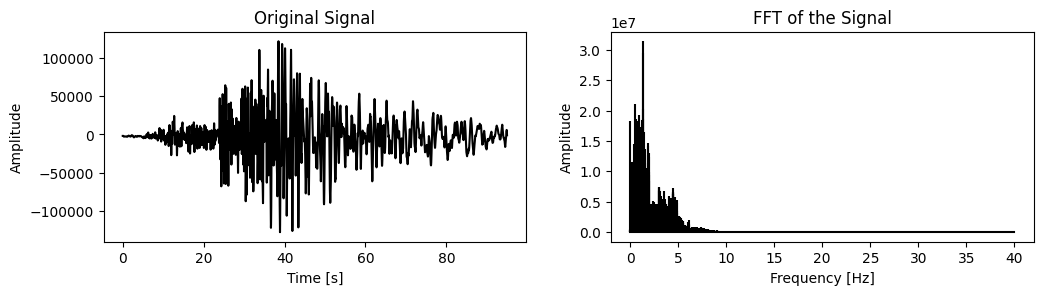

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
Fs = 80  # Sampling frequency (samples per second)
T = 1.0 / Fs  # Sampling interval (seconds)
t = np.arange(0, 95, 95/7601)  # Time vector (1 second duration)
signal = x[1][0]

# Compute the FFT of the signal
fft_signal = np.fft.fft(signal)

# Compute the corresponding frequencies
frequencies = np.fft.fftfreq(len(signal), T)

# Plot the original signal
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t, x[1][0], 'k')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the magnitude of the FFT
plt.subplot(2, 2, 2)
plt.stem(frequencies[:len(frequencies)//2], np.abs(fft_signal[:len(fft_signal)//2]), 'k', markerfmt=" ", basefmt="-k")
plt.title('FFT of the Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')